<a href="https://colab.research.google.com/github/gokul-pv/EVA6_Assignmets_Session5/blob/main/EVA6_Session_5_Code4_LRScheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Code4 - LR Scheduler**

Target

1. Add LR Scheduler

Results
1.   Parameters - 8,016
2.   Best training accuracy - 99.06%
3.   Best test accuracy - 99.44% (13th epoch)


Analysis
1. Reached the desired accuracy of 99.4 at 11th epoch.
2. LR Scheduler did help in getting to 99.4 or faster. 
3. Finding a good LR schedule is hard. Made it effective by reducing LR by 10th after the 10th epoch.
    
    







**Importing the necessary modules**

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import torchvision

**Data Transformations**

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])



# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like.It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [ ]:
'''Accessing a batch '''
sample_batch=next(iter(train_loader))
x1,y1=sample_batch

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


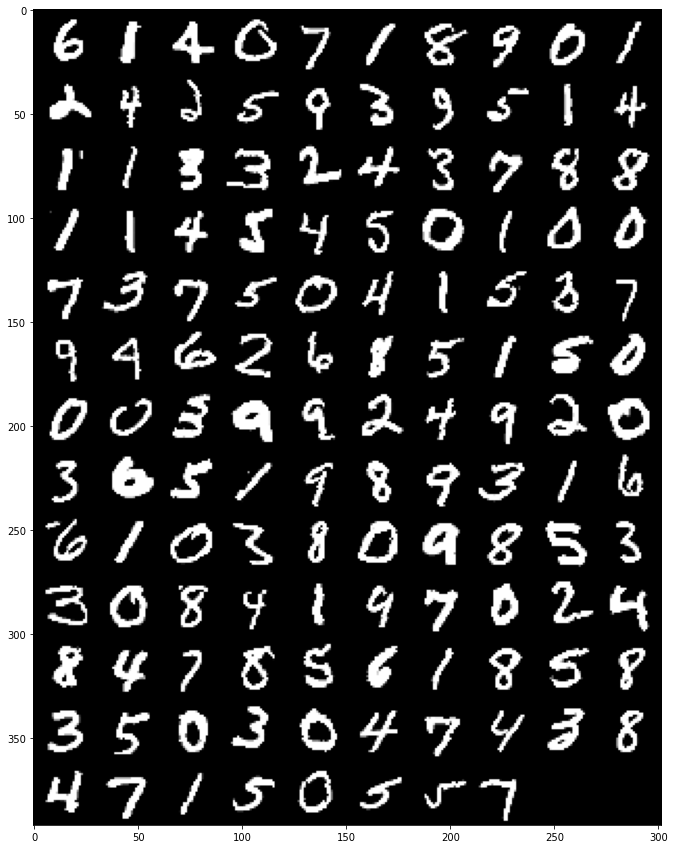

In [ ]:
'''Creating a grid of images'''
grid = torchvision.utils.make_grid(x1, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

**Defining the Model**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=0, bias=False),       #Input: 28*28*1  Output: 26 * 26 * 8     RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.02),

            nn.Conv2d(8, 10, 3, padding=0, bias=False),      #Input: 26*26*8  Output: 24 * 24 * 10    RF = 5 
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.02),

            nn.MaxPool2d(2, 2)                               #Input: 24*24*10  Output: 12 * 12 * 10   RF = 6       
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 12, 3, padding=0, bias=False),     #Input: 12*12*10  Output: 10 * 10 * 12   RF = 10 
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout2d(0.02),

            nn.Conv2d(12, 14, 3, padding=0, bias=False),     #Input: 10*10*12    Output: 8 * 8 * 14   RF = 14
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout2d(0.02),

            nn.Conv2d(14, 16, 3, padding=1, bias=False),     #Input: 8*8*16      Output: 8 * 8 * 16   RF = 18
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.02),

            nn.Conv2d(16, 16, 3, padding=0, bias=False),     #Input: 6*6*16      Output: 6 * 6 * 16   RF = 22
            nn.ReLU(),   
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.02)
        )
     

        self.avgpool = nn.AvgPool2d(6)                             # Global avergaing pooling is done to convert 2D data to 1D data Output: 1 * 1 * 16
        self.conv3   = nn.Conv2d(16, 10, 1, padding=0, bias=False) # a 1x1 convolution on 1D data is same as fully connected layer having 16 inputs and 10 outputs

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

**Model summary**

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
         Dropout2d-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
        Dropout2d-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


**Defining Train and Test Functions**

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Selecting the optmizer**

In [ ]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


**Training for 15 epoch**

In [ ]:
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)    

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.09020928293466568 Batch_id=468 Accuracy=88.71: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.05243094265460968 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9876/10000 (98.76%)

EPOCH: 2


Loss=0.08526042848825455 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Loss=0.029784753918647766 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.03646368160843849 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9924/10000 (99.24%)

EPOCH: 5


Loss=0.040552616119384766 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.07544754445552826 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.01632855460047722 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.06604835391044617 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.02984861470758915 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.05063764378428459 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.0635523721575737 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.1439337283372879 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.021502966061234474 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.0930868461728096 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)



**Ploting the loss**

Text(0.5, 1.0, 'Test Accuracy')

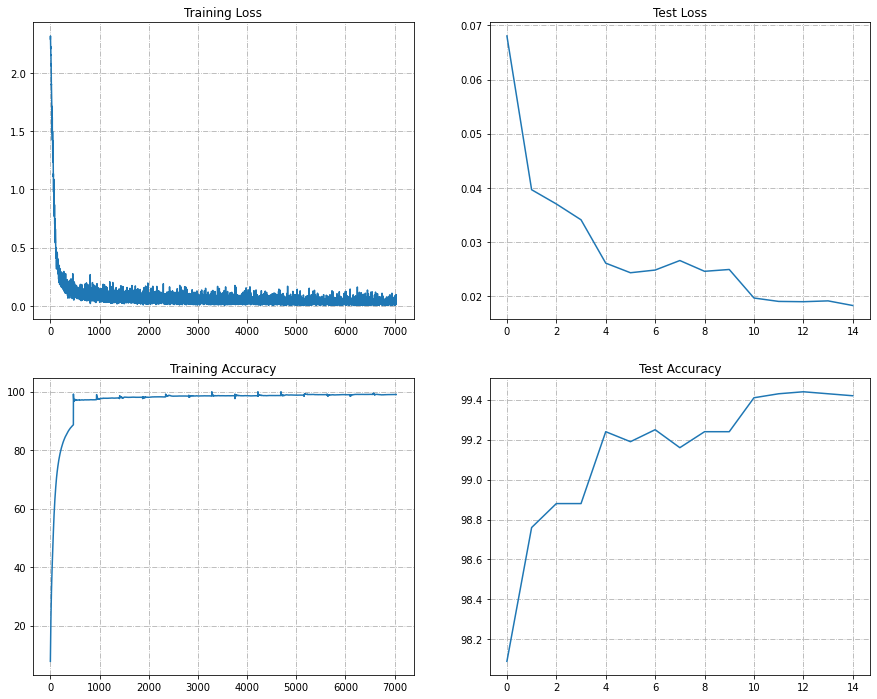

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,12))
axs[0, 0].plot(train_losses)
axs[0, 0].grid(linestyle='-.')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].grid(linestyle='-.')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].grid(linestyle='-.')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].grid(linestyle='-.')
axs[1, 1].set_title("Test Accuracy")